✅ Step 2: Import Required Libraries 🟢 Why?
These are essential libraries for data loading, visualization, text processing (TF-IDF), model training, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


🔹 Step 3: Load All 3 Files and Combine  🟢 Why?
Combining all the files ensures a unified dataset for consistent splitting and preprocessing across all models (NB, BiLSTM, CNN).

In [2]:
# Load all three text files (semicolon-delimited)
train_df = pd.read_csv('/content/drive/MyDrive/EmotionDetection project/train.txt', sep=';', header=None, names=['text', 'emotion'])
test_df  = pd.read_csv('/content/drive/MyDrive/EmotionDetection project/test.txt', sep=';', header=None, names=['text', 'emotion'])
val_df   = pd.read_csv('/content/drive/MyDrive/EmotionDetection project/val.txt', sep=';', header=None, names=['text', 'emotion'])

# Combine all into a single DataFrame
df = pd.concat([train_df, test_df, val_df], ignore_index=True)
df.head()


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


✅ Step 4: Explore the Dataset (Class Distribution) 🟢 Why?
To visually check class imbalance and how many examples each emotion has.



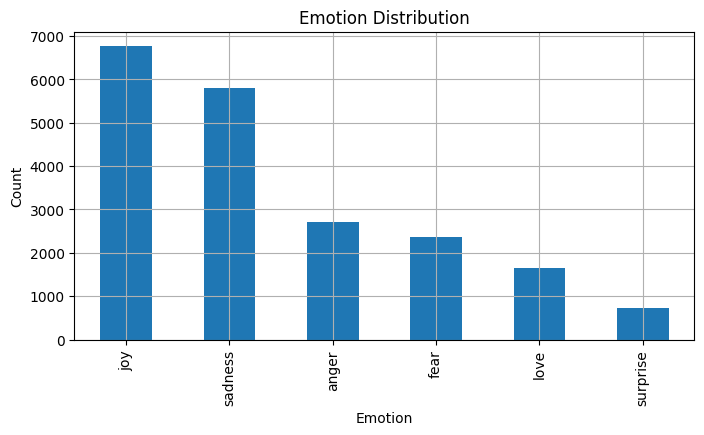

In [3]:
df['emotion'].value_counts().plot(kind='bar', title='Emotion Distribution', figsize=(8,4))
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.grid(True)
plt.show()


✅ Step 5: Split Dataset for Training and Testing  🟢 Why?
To separate data for training and testing while preserving the class ratio using stratify.



In [4]:
X = df['text']
y = df['emotion']

# 80/20 split with class balance (stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


✅ Step 6: Build and Train TF-IDF + Naive Bayes Model 🟢 Why TF-IDF?

Converts raw text to numerical vectors

Captures the importance of words (frequency vs. uniqueness)

🟢 Why Naive Bayes?

Fast and effective for text classification

Works well with TF-IDF (Bag of Words)

Excellent baseline model to compare against deep learning models later



In [5]:
# Create a pipeline: TF-IDF + Naive Bayes
model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('nb', MultinomialNB())
])

# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('nb', MultinomialNB())])

✅ Step 7: Evaluate the Model 🟢 Why this?
To measure precision, recall, F1-score, and visualize which classes are being predicted correctly or misclassified.

Accuracy: 75.22%

              precision    recall  f1-score   support

       anger       0.92      0.58      0.71       542
        fear       0.92      0.47      0.62       475
         joy       0.70      0.97      0.81      1352
        love       0.99      0.21      0.35       328
     sadness       0.74      0.93      0.82      1159
    surprise       1.00      0.07      0.13       144

    accuracy                           0.75      4000
   macro avg       0.88      0.54      0.57      4000
weighted avg       0.80      0.75      0.72      4000



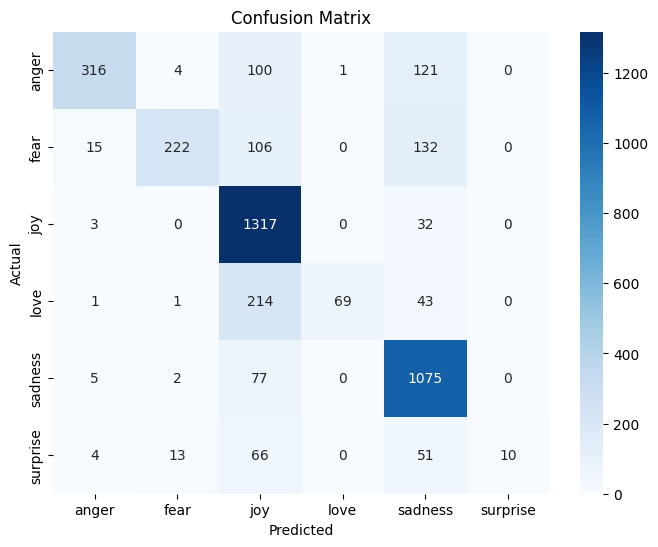

In [6]:
# Predict on test set
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%\n")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=model.classes_,
            yticklabels=model.classes_,
            cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


✅ Step 8: Predict on Custom Text 🟢 Why?
To test the model on real-world examples and see how well it generalizes.



In [7]:
def predict_emotion(text):
    return model.predict([text])[0]

# Example
predict_emotion("I'm extremely happy and excited!")


np.str_('joy')

#With new model BILSTM better than before
✅ Step 1: Encode Labels (Emotion → Number)
🟢 Why?
Deep learning needs numeric labels like 0, 1, 2, ... instead of strings like "joy", "anger".

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)


✅ Step 2: Tokenize and Convert Text to Sequences
🟢 Why?
Turns text like "I am happy" into [45, 12, 300] — numeric form for model input.

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set tokenizer parameters
vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


✅ Step 3: Pad Sequences
🟢 Why?
LSTM expects equal-length input, so we pad shorter sentences with 0s (e.g., [45, 12, 300, 0, 0, ...])

In [10]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


✅ Step 4: Build the BiLSTM Model
🟢 Why These Layers?
Layer	Purpose
Embedding-	Converts word indices into dense vectors (semantic meaning)
BiLSTM-	Learns word sequences in both directions
Dropout-	Prevents overfitting
Dense- (softmax)	Outputs probability of each emotion class

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=vocab_size, output_dim=64))
model_bilstm.add(Bidirectional(LSTM(64)))
model_bilstm.add(Dropout(0.5))
model_bilstm.add(Dense(32, activation='relu'))
model_bilstm.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_bilstm.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

# Force-build the model so summary works
model_bilstm.build(input_shape=(None, max_len))
model_bilstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 710,374 (2.71 MB)

 Trainable params: 710,374 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

✅ Step 5: Train the BiLSTM Model
🟢 What This Does:

Trains the BiLSTM model for 5 full passes (epochs) over training data

Uses 64 samples at a time (batch size)

Evaluates accuracy on validation (test) set during each epoch



In [12]:
history = model_bilstm.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_test_pad, y_test_enc),
    epochs=5,
    batch_size=64
)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3465 - loss: 1.5865 - val_accuracy: 0.6395 - val_loss: 0.9888
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7278 - loss: 0.7477 - val_accuracy: 0.8045 - val_loss: 0.5472
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8835 - loss: 0.3553 - val_accuracy: 0.8407 - val_loss: 0.4833
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9194 - loss: 0.2396 - val_accuracy: 0.8708 - val_loss: 0.4052
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9408 - loss: 0.1838 - val_accuracy: 0.8748 - val_loss: 0.4268


✅ Step 6: Evaluate the BiLSTM Model
🔹 6.1 Predict on Test Set

In [13]:
y_pred_prob = model_bilstm.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


🔹 6.2 Print Accuracy & Classification Report

In [14]:
from sklearn.metrics import accuracy_score, classification_report

# Accuracy
acc_bilstm = accuracy_score(y_test_enc, y_pred)
print(f"✅ BiLSTM Accuracy: {acc_bilstm * 100:.2f}%\n")

# Classification Report
print("🔎 Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))


✅ BiLSTM Accuracy: 87.48%

🔎 Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.84      0.86       542
        fear       0.85      0.82      0.83       475
         joy       0.87      0.94      0.91      1352
        love       0.74      0.80      0.77       328
     sadness       0.94      0.90      0.92      1159
    surprise       0.75      0.53      0.62       144

    accuracy                           0.87      4000
   macro avg       0.84      0.81      0.82      4000
weighted avg       0.88      0.87      0.87      4000



🔹 6.3 Confusion Matrix

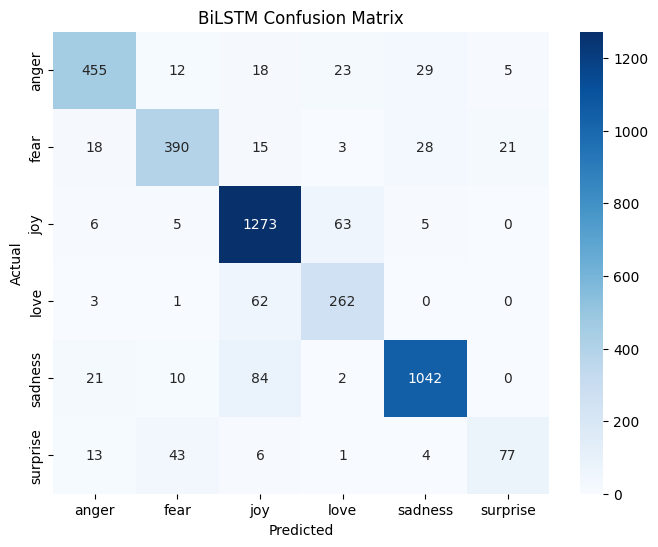

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.title('BiLSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


✅ Step 7: Predict Emotion for New Input

In [16]:
def predict_emotion_bilstm(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_bilstm.predict(pad)
    label = label_encoder.inverse_transform([np.argmax(pred)])
    return label[0]

# Example
predict_emotion_bilstm("I can't believe they did this to me. I'm furious!")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


'anger'

logging optional as accuracy is 40% run more epochs and it is custom text were training is happened for only 6 words as haappy , sad so on others are netural to get more accuracy run more epochs

In [17]:
import pandas as pd

# Test suite: (Text, Expected Emotion)
test_samples = [
    ("I'm tired of being ignored and disrespected.", "anger"),
    ("I feel so alone and broken inside.", "sadness"),
    ("I wasn’t expecting this at all. What a shock!", "surprise"),
    ("I’m afraid something terrible is going to happen.", "fear"),
    ("You complete me. I love everything about you.", "love"),
    ("This is the happiest day of my life!", "joy"),
    ("I just woke up and made coffee.", "neutral"),  # neutral not in original labels
    ("I won the competition! I can’t believe it!", "surprise"),
    ("That was so unfair.", "anger"),
    ("Thank you for always being there for me.", "love")
]

# Store results
results = []

# Loop through each sample and predict
for text, expected in test_samples:
    predicted = predict_emotion_bilstm(text)
    results.append({
        "Text": text,
        "Expected": expected,
        "Predicted": predicted,
        "Match": expected == predicted
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Show results
print("✅ Custom Emotion Prediction Evaluation:\n")
print(df_results[["Text", "Expected", "Predicted", "Match"]])

# Calculate and print custom accuracy
correct = df_results["Match"].sum()
total = len(df_results)
accuracy = (correct / total) * 100
print(f"\n📊 Accuracy on Custom Test Set: {accuracy:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
✅ Custom Emotion Prediction Evaluation:

                                                Text  Expected Predicted  \
0       I'm tired of being ignored and disrespected.     anger   sadness   
1                 I feel so alone and broken inside.   sadness   sadness   
2      I wasn’t expecting this at all. What a shock!  surprise      fear   
3  I’m afraid something terrible is going to happen.      fear      fear   
4      You complete me. I love everything about you.      love       joy   
5               This is the happiest day of my life!       joy      fear   
6                    I just woke up and made co

In [18]:
# using CNN MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=64))
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_cnn.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model_cnn.build(input_shape=(None, max_len))
model_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,414 (2.61 MB)

 Trainable params: 685,414 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the CNN Model

In [22]:
history_cnn = model_cnn.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_test_pad, y_test_enc),
    epochs=5,
    batch_size=64
)




Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3651 - loss: 1.5810 - val_accuracy: 0.7885 - val_loss: 0.6334
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8458 - loss: 0.4683 - val_accuracy: 0.9220 - val_loss: 0.2096
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9296 - loss: 0.2029 - val_accuracy: 0.9243 - val_loss: 0.1840
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9499 - loss: 0.1401 - val_accuracy: 0.9208 - val_loss: 0.1845
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9602 - loss: 0.1081 - val_accuracy: 0.9225 - val_loss: 0.1971


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ CNN Accuracy: 92.25%

🔎 Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.91      0.92       542
        fear       0.85      0.91      0.88       475
         joy       0.95      0.94      0.94      1352
        love       0.84      0.85      0.85       328
     sadness       0.95      0.96      0.96      1159
    surprise       0.83      0.70      0.76       144

    accuracy                           0.92      4000
   macro avg       0.89      0.88      0.89      4000
weighted avg       0.92      0.92      0.92      4000



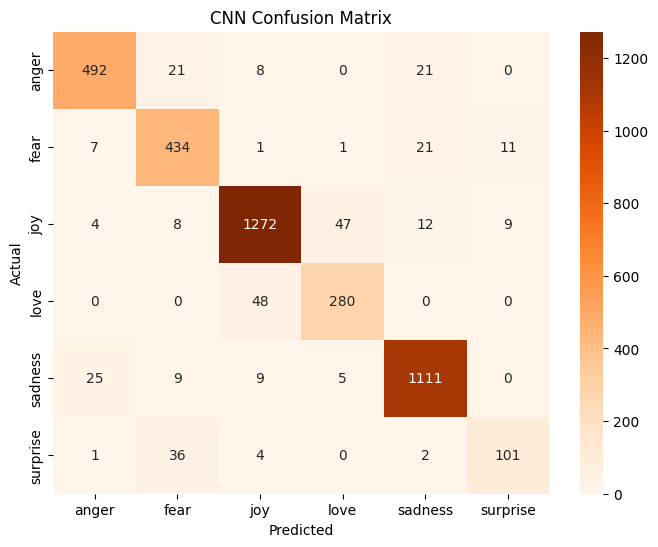

In [23]:
#Evaluate the CNN Model
y_pred_cnn_prob = model_cnn.predict(X_test_pad)
y_pred_cnn = np.argmax(y_pred_cnn_prob, axis=1)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
acc_cnn = accuracy_score(y_test_enc, y_pred_cnn)
print(f"✅ CNN Accuracy: {acc_cnn * 100:.2f}%\n")

# Classification Report
print("🔎 Classification Report:")
print(classification_report(y_test_enc, y_pred_cnn, target_names=label_encoder.classes_))

# Confusion Matrix
cm_cnn = confusion_matrix(y_test_enc, y_pred_cnn)

plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Oranges')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [26]:
#Predict Emotion on Custom Text (CNN)
def predict_emotion_cnn(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_cnn.predict(pad)
    label = label_encoder.inverse_transform([np.argmax(pred)])
    return label[0]

# Example
predict_emotion_cnn("I’m feeling nervous and scared for tomorrow.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


'fear'